# Wind farm yaw control, simple

Assume we have a wind farm with three wind turbines and we want to optimize the total farm production via yaw misalignment control.

- Wind turbines: 3 x DTU 10MW reference wind turbines
- Distance: 5D (892m)
- Wind speed: 10 m/s
- Wind direction: 240-300$^\circ$
- Turbulence intensity: 10%

Simplifications:
- Power-ct relation follows cosine law
- 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from py_wake.examples.data.dtu10mw._dtu10mw import DTU10MW
from py_wake.utils.plotting import setup_plot
from dynamiks.utils import doc_utils

In [2]:
wt = DTU10MW()
wt_x = np.arange(3) * 5 * wt.diameter()
wt_y = wt_x * 0
U = 10
wd_lst = np.arange(240, 301,2)
TI = .06

## Find optimial yaw settings

### Optimize with Topfarm and PyWake

To find the optimal yaw settings for wind directions from 240-300$^\circ$ we set up a Topfarm optimization with $yaw(wt,wd)$ as design variables and using PyWake AEP as the objective to maximize.

Alternatively you can use the hard coded refernce values [below](#Hard-coded-yaw-tabular)

In [3]:
# setup PyWake AEP and gradient function
from py_wake.wind_farm_models.engineering_models import PropagateDownwind
from py_wake.site._site import UniformSite
from py_wake.deficit_models.gaussian import NiayifarGaussianDeficit
from py_wake.deflection_models.gcl_hill_vortex import GCLHillDeflection
from py_wake.turbulence_models.crespo import CrespoHernandez
from py_wake.utils.gradients import autograd
from py_wake.rotor_avg_models.rotor_avg_model import CGIRotorAvg


wt = DTU10MW()
wfm = PropagateDownwind(UniformSite(ws=U, ti=TI), wt, NiayifarGaussianDeficit(),
                        deflectionModel=GCLHillDeflection(),
                        turbulenceModel=CrespoHernandez(),
                        rotorAvgModel=CGIRotorAvg(21))
wt_x = np.arange(3) * 5 * wt.diameter()
wt_y = wt_x * 0
wd_lst = np.arange(240, 301,2)
yaw = np.ones((3, len(wd_lst))) # one deg misalignment as initial guess to get out of local minimum at 0deg

def aep(yaw):
    return wfm.aep(wt_x, wt_y, yaw=yaw.reshape((3, len(wd_lst))), tilt=0, wd=wd_lst)

def daep(yaw):
    return [autograd(aep)(yaw)]

def plot(yaw,wd):
    wfm(wt_x, wt_y, yaw=yaw, tilt=0, wd=wd).flow_map().plot_wake_map()

In [23]:
%%capture
# setup topfarm problem and optimize
try:
    import topfarm
except ModuleNotFoundError:
    !pip install topfarm # install topfarm if not installed

In [ ]:
from topfarm._topfarm import TopFarmProblem
from topfarm.cost_models.cost_model_wrappers import AEPCostModelComponent
cost_comp = AEPCostModelComponent(input_keys=['yaw'], n_wt=len(yaw.flatten()),
                                  cost_function=aep, cost_gradient_function=daep)
tf = TopFarmProblem(design_vars={'yaw': (yaw.flatten(), -40, 40)}, cost_comp=cost_comp, n_wt=len(yaw.flatten()))

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


In [5]:
tf.optimize()
yaw_tabular = tf.state['yaw'].reshape((3, len(wd_lst)))
yaw_tabular = np.round(yaw_tabular).astype(int)
print(yaw_tabular)

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Optimization terminated successfully    (Exit mode 0)
            Current function value: -29.651020222966046
            Iterations: 98
            Function evaluations: 104
            Gradient evaluations: 98
Optimization Complete
-----------------------------------
[[  0   0   0   0   0   0  -1  -2  -4  -6  -8 -11 -15 -18 -22  25  22  18
   15  11   8   6   4   2   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0  -1  -2  -4  -6  -8 -11 -14 -17 -20  24  20  17
   14  11   8   6   4   2   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [6]:
print(str(yaw_tabular.tolist()).replace(" ",""))

[[0,0,0,0,0,0,-1,-2,-4,-6,-8,-11,-15,-18,-22,25,22,18,15,11,8,6,4,2,1,0,0,0,0,0,0],[0,0,0,0,0,0,-1,-2,-4,-6,-8,-11,-14,-17,-20,24,20,17,14,11,8,6,4,2,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]


### Hard coded yaw tabular

In [7]:
yaw_tabular=np.array([[0,0,0,0,0,0,-1,-2,-4,-6,-8,-11,-15,-18,-22,25,22,18,15,11,8,6,4,2,1,0,0,0,0,0,0],
                      [0,0,0,0,0,0,-1,-2,-4,-6,-8,-11,-14,-17,-20,24,20,17,14,11,8,6,4,2,1,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

### Plot optimial yaw settings

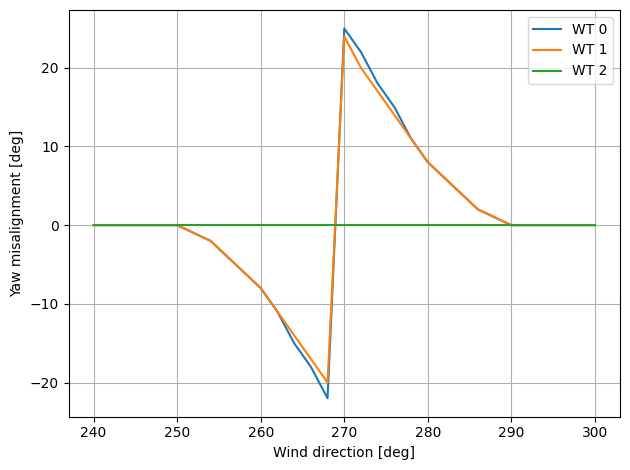

In [8]:
for i, y_ in enumerate(yaw_tabular):
    plt.plot(wd_lst, y_, label=f'WT {i}')
setup_plot(xlabel='Wind direction [deg]', ylabel='Yaw misalignment [deg]')

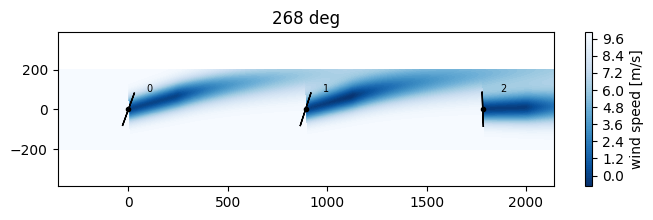

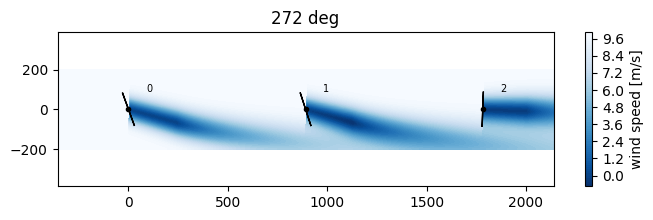

In [9]:
for wd in [268,272]:
    plt.figure(figsize=(8,2))
    plot(yaw_tabular[:,wd_lst==wd][:,0],wd)
    plt.title(f'{wd} deg')

## Dynamiks wind farm control

### Wind farm controller

In [10]:
def simple_wind_farm_controller(flowSimulation):
    wd = flowSimulation.wind_direction
    wd_index = np.argmin(np.abs(wd_lst - wd))
    yaw = yaw_tabular[:,wd_index]
    flowSimulation.windTurbines.yaw = yaw

### Wind direction changer

In [11]:
def wind_direction_changer(flowSimulation):
    flowSimulation.wind_direction = 260+flowSimulation.time/100    

### Dynamiks DWMFlowSimulation

In [12]:
from dynamiks.utils.test_utils import DefaultDWMFlowSimulation, DemoSite
from dynamiks.dwm.particle_motion_models import HillVortexParticleMotion
from dynamiks.wind_turbines.pywake_windturbines import PyWakeWindTurbines
from dynamiks.views import XYView, EastNorthView, MultiView

wts = PyWakeWindTurbines(x=wt_x, y=wt_y, windTurbine=DTU10MW())
fs = DefaultDWMFlowSimulation(windTurbines=wts, particleMotionModel=HillVortexParticleMotion(),
                          d_particle=.1, n_particles=100, ti=TI, ws=U,
                          step_handlers=[wind_direction_changer, simple_wind_farm_controller])

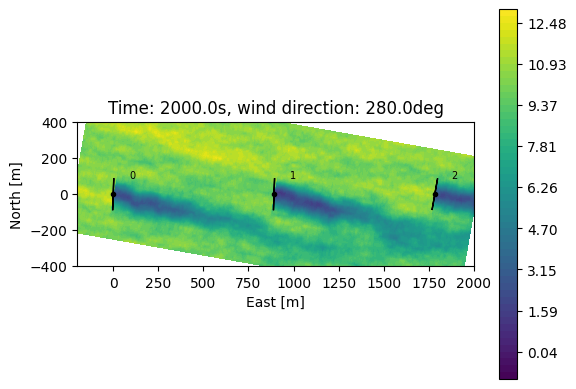

In [13]:
fs.visualize(2000, dt=10, interval=.1, view=EastNorthView(
    x=np.linspace(-200, 2000, 500), y=np.linspace(-400, 400),
    visualizers=[lambda fs: plt.title(f'Time: {fs.time}s, wind direction: {fs.wind_direction}deg')]), id='WindFarmControlSimple')

In [14]:
fs.run(2000, verbose=1)
power_yaw_control = wts.sensors.to_xarray(dataset=True).power

0it [00:00, ?it/s]

In [15]:
wts = PyWakeWindTurbines(x=wt_x, y=wt_y, windTurbine=DTU10MW())
fs_baseline = DefaultDWMFlowSimulation(windTurbines=wts, particleMotionModel=HillVortexParticleMotion(),
                          d_particle=.1, n_particles=100, ti=TI, ws=U,
                          step_handlers=[wind_direction_changer])
fs_baseline.run(2000, verbose=1)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
power_baseline = wts.sensors.to_xarray(dataset=True).power

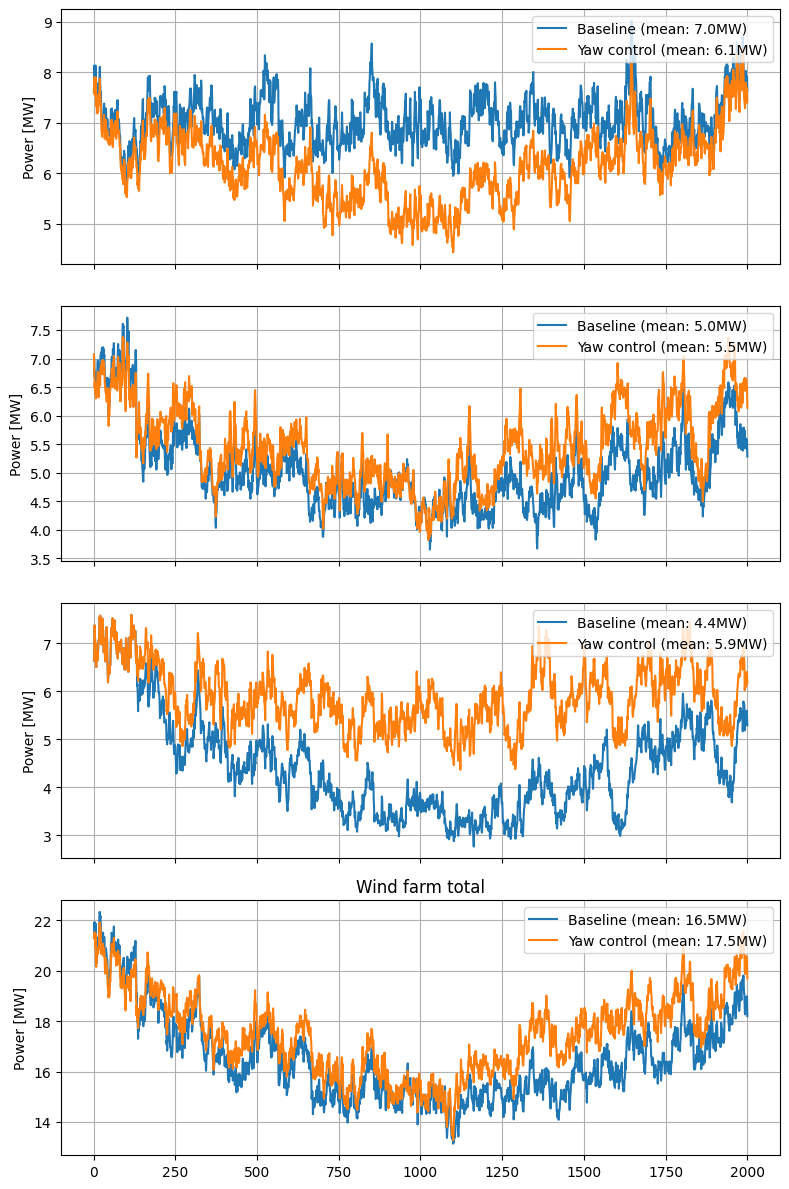

In [17]:
axes = plt.subplots(4,1, figsize=(8,12), sharex=True)[1]
for wt, ax in zip(power_yaw_control.wt, axes):
    for p,n in [(power_baseline,'Baseline'),(power_yaw_control,'Yaw control')]:
        p = p.sel(wt=wt)/1e6
        p.plot(ax=ax, label=f'{n} (mean: {p.mean().item():.1f}MW)')
    setup_plot(ax=ax,ylabel='Power [MW]')
    ax.legend(loc=1)
for p,n in [(power_baseline,'Baseline'),(power_yaw_control,'Yaw control')]:
    p = p.sum('wt')/1e6
    p.plot(ax=axes[3], label=f'{n} (mean: {p.mean().item():.1f}MW)')
setup_plot(ax=axes[3],ylabel='Power [MW]', title='Wind farm total')
axes[3].legend(loc=1)

plt.tight_layout()

## Issues and simplifications

Simplifications:

- Power and ct follows the cosine law
  - $ct_{x} = ct_{normal}(U \cos{\theta_{yaw}}) \cos{\theta_{yaw}}^2$
  - $Power = Power(U \cos{\theta_{yaw}})$
- Wind turbine yaws instantaneous
- Mean Wind direction known from input
- Smooth change of mean wind direction from 260 to 280 deg